# Creating & Combining 11 ICPAC Countries Shapefile

In [2]:
# merge_all_icpac_shapefiles.py
import geopandas as gpd
import pandas as pd
import os
import glob

# === Set your folder path ===
input_folder = "/Users/mac/Downloads/admin1"

# === Find all .shp files in the folder ===
shapefiles = glob.glob(os.path.join(input_folder, "*.shp"))

print("🗂️ Shapefiles found:")
for shp in shapefiles:
    print(f" - {os.path.basename(shp)}")

# === Check if shapefiles exist ===
if not shapefiles:
    raise FileNotFoundError("No .shp files found in the folder. Please check your path.")

# === Load and merge all shapefiles ===
gdfs = []
for shp in shapefiles:
    print(f"✅ Loading {os.path.basename(shp)}...")
    gdf = gpd.read_file(shp)
    gdfs.append(gdf)

# Combine all shapefiles into one GeoDataFrame
merged = gpd.GeoDataFrame(pd.concat(gdfs, ignore_index=True), crs=gdfs[0].crs)

# === Save the merged shapefile ===
output_shapefile = os.path.join(input_folder, "icpac_countries_merged.shp")
merged.to_file(output_shapefile)

print(f"\n🎉 Merged shapefile successfully created at:\n{output_shapefile}")


🗂️ Shapefiles found:
 - gadm41_DJI_0.shp
 - gadm41_ETH_0.shp
 - gadm41_ERI_0.shp
 - gadm41_SDN_0.shp
 - gadm41_TZA_0.shp
 - gadm41_SSD_0.shp
 - gadm41_KEN_0.shp
 - gadm41_RWA_0.shp
 - gadm41_UGA_0.shp
 - gadm41_BDI_0.shp
 - gadm41_SOM_0.shp
✅ Loading gadm41_DJI_0.shp...
✅ Loading gadm41_ETH_0.shp...
✅ Loading gadm41_ERI_0.shp...
✅ Loading gadm41_SDN_0.shp...
✅ Loading gadm41_TZA_0.shp...
✅ Loading gadm41_SSD_0.shp...
✅ Loading gadm41_KEN_0.shp...
✅ Loading gadm41_RWA_0.shp...
✅ Loading gadm41_UGA_0.shp...
✅ Loading gadm41_BDI_0.shp...
✅ Loading gadm41_SOM_0.shp...

🎉 Merged shapefile successfully created at:
/Users/mac/Downloads/admin1/icpac_countries_merged.shp


,GID_0,COUNTRY,geometry
0,DJI,Djibouti,"MULTIPOLYGON (((43.0834 11.18196, 43.08249 11...."
1,ETH,Ethiopia,"POLYGON ((38.43719 3.60126, 38.42982 3.60086, ..."
2,ERI,Eritrea,"MULTIPOLYGON (((42.93319 12.81847, 42.93264 12..."
3,SDN,Sudan,"MULTIPOLYGON (((24.22412 8.70359, 24.22338 8.7..."
4,TZA,Tanzania,"MULTIPOLYGON (((39.35587 -11.09155, 39.34812 -..."


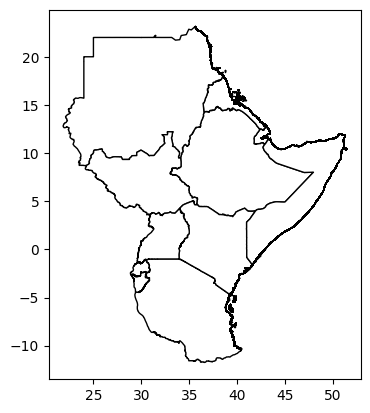

In [13]:
import geopandas as gpd
gdf = gpd.read_file("/Users/mac/Downloads/admin1/icpac_countries_merged.shp")

# Fill of the map should be white with black borders
gdf.plot(facecolor='white', edgecolor='black')

gdf.head()

# Download CDI GeoTIFFs (2020–2023)

In [7]:
# import os
# import requests
# from bs4 import BeautifulSoup
# from tqdm import tqdm

# # === CONFIGURATION ===
# BASE_URL = "https://droughtwatch.icpac.net/ftp/monthly/geotif/"
# OUT_DIR = "/Users/mac/Projects/Drought2020_2023/CDI_raw/"
# YEARS = ["2020", "2021", "2022", "2023"]

# # Create output directory
# os.makedirs(OUT_DIR, exist_ok=True)

# def get_tif_links(year_url):
#     """Scrape .tif links for a given year folder."""
#     try:
#         response = requests.get(year_url, timeout=30)
#         response.raise_for_status()
#         soup = BeautifulSoup(response.text, "html.parser")
#         links = [
#             a["href"] for a in soup.find_all("a")
#             if a["href"].lower().endswith(".tif")
#         ]
#         return links
#     except Exception as e:
#         print(f"⚠️ Error accessing {year_url}: {e}")
#         return []

# def download_file(url, save_path):
#     """Download a file with progress bar."""
#     try:
#         with requests.get(url, stream=True, timeout=60) as r:
#             r.raise_for_status()
#             total = int(r.headers.get("content-length", 0))
#             with open(save_path, "wb") as f, tqdm(
#                 total=total,
#                 unit="B",
#                 unit_scale=True,
#                 desc=os.path.basename(save_path),
#                 ncols=80
#             ) as pbar:
#                 for chunk in r.iter_content(chunk_size=8192):
#                     if chunk:
#                         f.write(chunk)
#                         pbar.update(len(chunk))
#     except Exception as e:
#         print(f"⚠️ Failed to download {url}: {e}")

# # === MAIN WORKFLOW ===
# for year in YEARS:
#     year_url = f"{BASE_URL}{year}/"
#     print(f"\n📅 Processing year {year} → {year_url}")

#     tif_links = get_tif_links(year_url)
#     if not tif_links:
#         print(f"⚠️ No .tif files found for {year}")
#         continue

#     year_dir = os.path.join(OUT_DIR, year)
#     os.makedirs(year_dir, exist_ok=True)

#     for tif_name in tif_links:
#         file_url = f"{year_url}{tif_name}"
#         save_path = os.path.join(year_dir, tif_name)

#         if os.path.exists(save_path):
#             print(f"⏭️ Skipping existing file: {tif_name}")
#             continue

#         print(f"⬇️ Downloading {tif_name} ...")
#         download_file(file_url, save_path)

# print("\n✅ All CDI GeoTIFFs (2020–2023) downloaded successfully!")
# print(f"📂 Saved in: {OUT_DIR}")


## workflow so that after generating the monthly CDI maps, the script computes the mean CDI value per month (for the entire ICPAC region or per country, if you wish) and plots a time series showing the evolution of drought from 2020–2023.

In [22]:
import os
import glob
import rasterio
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from rasterio.mask import mask
from rasterio.plot import show
from datetime import datetime
import pandas as pd

# === PATHS ===
cdi_folder = "/Users/mac/Documents/analysis/Drought_Monitoring/cdi_files"
shapefile_path = "/Users/mac/Downloads/admin1/icpac_countries_merged.shp"
output_folder = "/Users/mac/Documents/analysis/Drought_Monitoring/cdi_clipped"

os.makedirs(output_folder, exist_ok=True)

# === LOAD SHAPEFILE ===
region = gpd.read_file(shapefile_path)
region = region.to_crs(epsg=4326)

# === CDI COLOR MAP ===
# 1–3 = Watch (Yellow), 4–6 = Warning (Orange), 7–10 = Alert (Red)
colors = {
    1: "#FFFF99", 2: "#FFFF66", 3: "#FFEE33",     # Light–mid yellow (Watch)
    4: "#FFCC66", 5: "#FF9933", 6: "#FF6600",     # Orange (Warning)
    7: "#FF3333", 8: "#CC0000", 9: "#990000", 10: "#660000"  # Red shades (Alert)
}

# === CLASSIFY FUNCTION ===
def classify_cdi(data):
    """Assigns classification codes for CDI severity."""
    classified = np.full_like(data, np.nan)
    for val in colors.keys():
        classified[data == val] = val
    return classified

# === DATE PARSER ===
def parse_date(filename):
    name = os.path.splitext(os.path.basename(filename))[0]
    try:
        return datetime.strptime(name, "%Y-%b")
    except:
        return None

# === COLLECT RASTERS ===
tif_files = sorted(glob.glob(os.path.join(cdi_folder, "*.tif")))
tif_files = [f for f in tif_files if parse_date(f) is not None]
tif_files.sort(key=lambda x: parse_date(x))

mean_vals = []
dates = []

# === PROCESS EACH RASTER ===
for tif in tif_files:
    date = parse_date(tif)
    if not date:
        continue

    try:
        with rasterio.open(tif) as src:
            # Clip to region boundary
            clipped, transform = mask(src, region.geometry, crop=True)
            data = clipped[0]
            data = np.where(data == src.nodata, np.nan, data)

            # Compute mean CDI
            mean_val = np.nanmean(data)
            mean_vals.append(mean_val)
            dates.append(date)

            # Classify CDI values
            classified = classify_cdi(data)

            # === VISUALIZATION ===
            fig, ax = plt.subplots(figsize=(8, 6))
            cmap = plt.matplotlib.colors.ListedColormap(list(colors.values()))
            norm = plt.matplotlib.colors.BoundaryNorm(list(colors.keys()) + [11], cmap.N)

            show(classified, transform=transform, ax=ax, cmap=cmap, norm=norm)

            # Overlay faint country boundaries
            region.boundary.plot(ax=ax, color="black", linewidth=0.6, alpha=0.4)

            ax.set_title(f"Combined Drought Index (CDI) – {date.strftime('%B %Y')}", fontsize=13)
            ax.axis("off")

            # Save map
            output_path = os.path.join(output_folder, f"CDI_{date.strftime('%Y_%m')}.png")
            plt.savefig(output_path, bbox_inches="tight", dpi=300)
            plt.close()

            print(f"✅ Map saved: {output_path}")

    except Exception as e:
        print(f"❌ Error processing {tif}: {e}")

# === TIME SERIES PLOT ===
if mean_vals:
    df = pd.DataFrame({"Date": dates, "Mean_CDI": mean_vals})
    df = df.sort_values("Date")

    plt.figure(figsize=(10, 5))
    plt.plot(df["Date"], df["Mean_CDI"], color="blue", marker="o", linewidth=2)
    plt.title("Evolution of Combined Drought Index (2020–2023)", fontsize=14)
    plt.xlabel("Date")
    plt.ylabel("Mean CDI Value")
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.tight_layout()

    ts_path = os.path.join(output_folder, "CDI_Timeseries_2020_2023.png")
    plt.savefig(ts_path, dpi=300)
    plt.close()

    df.to_csv(os.path.join(output_folder, "CDI_mean_timeseries.csv"), index=False)
    print(f"\n📈 Time series and CSV saved to: {output_folder}")
else:
    print("⚠️ No CDI data processed.")


✅ Map saved: /Users/mac/Documents/analysis/Drought_Monitoring/cdi_clipped/CDI_2020_01.png
✅ Map saved: /Users/mac/Documents/analysis/Drought_Monitoring/cdi_clipped/CDI_2020_02.png
✅ Map saved: /Users/mac/Documents/analysis/Drought_Monitoring/cdi_clipped/CDI_2020_03.png
✅ Map saved: /Users/mac/Documents/analysis/Drought_Monitoring/cdi_clipped/CDI_2020_04.png
✅ Map saved: /Users/mac/Documents/analysis/Drought_Monitoring/cdi_clipped/CDI_2020_05.png
✅ Map saved: /Users/mac/Documents/analysis/Drought_Monitoring/cdi_clipped/CDI_2020_06.png
✅ Map saved: /Users/mac/Documents/analysis/Drought_Monitoring/cdi_clipped/CDI_2020_07.png
✅ Map saved: /Users/mac/Documents/analysis/Drought_Monitoring/cdi_clipped/CDI_2020_08.png
✅ Map saved: /Users/mac/Documents/analysis/Drought_Monitoring/cdi_clipped/CDI_2020_09.png
✅ Map saved: /Users/mac/Documents/analysis/Drought_Monitoring/cdi_clipped/CDI_2020_10.png
✅ Map saved: /Users/mac/Documents/analysis/Drought_Monitoring/cdi_clipped/CDI_2020_11.png
✅ Map save

# ICPAC Drought Visualization Pipeline

- Acting as a pipeline, this script processes monthly CDI rasters from 2020 to 2023 for the ICPAC region, clipping to its shapefile. It classifies drought levels, excludes waterbodies, adds country labels, and outputs PNG maps with a detailed legend for regional insights.


In [13]:
#!/usr/bin/env python3
"""
generate_cdi_maps.py
--------------------

This script reads monthly Combined Drought Indicator (CDI) raster files (2020–2023),
clips them to the ICPAC region shapefile, classifies drought stages, removes no-data
areas (waterbodies), labels countries, adds a continuous colorbar legend, ICPAC logo,
and disclaimer text within a framed layout (with latitude/longitude gridlines).
Saves each map as a PNG and generates a CDI time series plot.

Author: Mark Lelaono
"""

import os
import glob
import rasterio
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from rasterio.mask import mask
from rasterio.plot import show
from datetime import datetime
import pandas as pd
from matplotlib.colors import LinearSegmentedColormap, BoundaryNorm
import matplotlib.patches as mpatches
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from PIL import Image

# === PATHS ===
cdi_folder = "/Users/mac/Documents/analysis/Drought_Monitoring/cdi_files"
region_shapefile_path = "/Users/mac/Downloads/admin1/icpac_countries_merged.shp"
waterbody_shapefile_path = "/Users/mac/Downloads/admin1/water_bodies.shp"
icpac_logo_path = "/Users/mac/Downloads/ICPAC_LOGO.png" 
output_folder = "/Users/mac/Documents/analysis/Drought_Monitoring/cdi_clipped"
os.makedirs(output_folder, exist_ok=True)

# === LOAD SHAPEFILES ===
region = gpd.read_file(region_shapefile_path).to_crs(epsg=4326)
waterbodies = gpd.read_file(waterbody_shapefile_path).to_crs(epsg=4326)

# === CDI COLOR MAP ===
colors = {
    1: "#FFFF99", 2: "#FFFF66", 3: "#FFEE33",  # Watch (Yellow)
    4: "#FFCC66", 5: "#FF9933", 6: "#FF6600",  # Warning (Orange)
    7: "#FF3333", 8: "#CC0000", 9: "#990000", 10: "#660000"  # Alert (Red)
}

# === CLASSIFY FUNCTION ===
def classify_cdi(data):
    classified = np.full_like(data, np.nan)
    for val in colors.keys():
        classified[data == val] = val
    return classified

# === DATE PARSER ===
def parse_date(filename):
    name = os.path.splitext(os.path.basename(filename))[0]
    try:
        return datetime.strptime(name, "%Y-%b")
    except Exception:
        return None

# === COLLECT RASTERS ===
tif_files = sorted(glob.glob(os.path.join(cdi_folder, "*.tif")))
tif_files = [f for f in tif_files if parse_date(f) is not None]
tif_files.sort(key=lambda x: parse_date(x))

mean_vals = []
dates = []

# === PROCESS EACH RASTER ===
for tif in tif_files:
    date = parse_date(tif)
    if not date:
        continue

    try:
        with rasterio.open(tif) as src:
            # Clip raster to region
            clipped, transform = mask(src, region.geometry, crop=True)
            data = clipped[0]
            data = np.where(data == src.nodata, np.nan, data)

            # Compute mean CDI
            mean_val = np.nanmean(data)
            mean_vals.append(mean_val)
            dates.append(date)

            # Classify CDI
            classified = classify_cdi(data)

            # === Visualization ===
            fig, ax = plt.subplots(figsize=(8, 6))

            # Define continuous colorbar (No Drought → Watch → Warning → Alert)
            boundaries = [0, 1, 4, 7, 11]
            colors_list = ['#FFFFFF', '#FFFF00', '#FFA500', '#FF0000']
            cmap = LinearSegmentedColormap.from_list('cdi_drought', colors_list, N=len(colors_list))
            norm = BoundaryNorm(boundaries, cmap.N, clip=True)

            # Plot classified raster
            im = show(classified, transform=transform, ax=ax, cmap=cmap, norm=norm)

            # Plot boundaries and waterbodies
            region.boundary.plot(ax=ax, color="black", linewidth=0.6, alpha=0.5)
            waterbodies.plot(ax=ax, color="#90D5FF", alpha=0.5)

            # === Add Country Labels ===
            region["centroid"] = region.geometry.centroid
            for _, row in region.iterrows():
                country_name = (
                    row["COUNTRY"]
                    if "COUNTRY" in region.columns
                    else row.get("NAME_0", "")
                )
                x, y = row.centroid.x, row.centroid.y

                # Adjust Somalia label manually
                if country_name.lower().startswith("som"):
                    x += 2.5
                    y += 0.5

                ax.text(
                    x, y, country_name,
                    fontsize=6, color="black",
                    ha="center", va="center",
                    alpha=0.8, weight="normal"
                )

            # === Add gridlines (lat/lon) ===
            ax.set_xticks(np.arange(20, 55, 5))
            ax.set_yticks(np.arange(-10, 25, 5))
            ax.set_xticklabels([f"{x}°E" for x in np.arange(20, 55, 5)], fontsize=8)
            ax.set_yticklabels([f"{y}°N" for y in np.arange(-10, 25, 5)], fontsize=8)
            # ax.grid(which="both", color="gray", linestyle="--", linewidth=0.5, alpha=0.4)

            # === Continuous Colorbar Legend ===
            cbar = plt.colorbar(
                im.get_images()[0],
                ax=ax,
                fraction=0.046, pad=0.04,
                boundaries=boundaries,
                ticks=[0.5, 2, 5, 8.5]
            )
            cbar.ax.set_yticklabels(['No Drought', 'Watch', 'Warning', 'Alert'], fontsize=7)
            cbar.ax.tick_params(labelsize=7)

            # === Title ===
            ax.set_title(
                f"Combined Drought Index (CDI) – {date.strftime('%B %Y')}",
                fontsize=12, fontweight='bold', pad=15
            )

            # === Add Frame ===
            xmin, xmax = ax.get_xlim()
            ymin, ymax = ax.get_ylim()
            frame = mpatches.Rectangle(
                (xmin, ymin),
                xmax - xmin,
                ymax - ymin,
                fill=False,
                color='black',
                linewidth=1.2,
                zorder=10,
                transform=ax.transData
            )
            ax.add_patch(frame)

            # === Add ICPAC Logo (Top-Right) ===
            if os.path.exists(icpac_logo_path):
                logo = Image.open(icpac_logo_path)
                logo.thumbnail((90, 90))  # Reduce logo size
                imagebox = OffsetImage(logo, zoom=0.35)
                ab = AnnotationBbox(
                    imagebox, (xmax - 1.5, ymax - 1.5),
                    frameon=False, box_alignment=(1, 1),
                    xycoords='data'
                )
                ax.add_artist(ab)

            # === Add Disclaimer ===
            ax.text(
                (xmin + xmax) / 2, ymin + 0.4,
                "Disclaimer: The country boundaries are not endorsed by ICPAC.",
                ha="center", va="bottom",
                fontsize=7, color="black", style="italic",
                transform=ax.transData
            )

            # Save Map
            output_path = os.path.join(output_folder, f"CDI_{date.strftime('%Y_%m')}.png")
            plt.savefig(output_path, bbox_inches="tight", dpi=300)
            plt.close()
            print(f"✅ Map saved (with frame, logo, grid & disclaimer): {output_path}")

    except Exception as e:
        print(f"❌ Error processing {tif}: {e}")

# === TIME SERIES PLOT ===
if mean_vals:
    df = pd.DataFrame({"Date": dates, "Mean_CDI": mean_vals}).sort_values("Date")
    plt.figure(figsize=(10, 5))
    plt.plot(df["Date"], df["Mean_CDI"], color="blue", marker="o", linewidth=2)
    plt.title("Evolution of Combined Drought Index (2020–2023)", fontsize=14)
    plt.xlabel("Date")
    plt.ylabel("Mean CDI Value")
    plt.tight_layout()

    ts_output = os.path.join(output_folder, "CDI_Timeseries.png")
    plt.savefig(ts_output, dpi=1000)
    plt.close()
    print(f"📈 Time series saved: {ts_output}")


/var/folders/wh/2jywb0qs5mv176y3j4zylm140000gn/T/ipykernel_3904/3407300160.py:110: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  region["centroid"] = region.geometry.centroid


✅ Map saved (with frame, logo, grid & disclaimer): /Users/mac/Documents/analysis/Drought_Monitoring/cdi_clipped/CDI_2020_01.png


/var/folders/wh/2jywb0qs5mv176y3j4zylm140000gn/T/ipykernel_3904/3407300160.py:110: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  region["centroid"] = region.geometry.centroid


✅ Map saved (with frame, logo, grid & disclaimer): /Users/mac/Documents/analysis/Drought_Monitoring/cdi_clipped/CDI_2020_02.png


/var/folders/wh/2jywb0qs5mv176y3j4zylm140000gn/T/ipykernel_3904/3407300160.py:110: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  region["centroid"] = region.geometry.centroid


✅ Map saved (with frame, logo, grid & disclaimer): /Users/mac/Documents/analysis/Drought_Monitoring/cdi_clipped/CDI_2020_03.png


/var/folders/wh/2jywb0qs5mv176y3j4zylm140000gn/T/ipykernel_3904/3407300160.py:110: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  region["centroid"] = region.geometry.centroid


✅ Map saved (with frame, logo, grid & disclaimer): /Users/mac/Documents/analysis/Drought_Monitoring/cdi_clipped/CDI_2020_04.png


/var/folders/wh/2jywb0qs5mv176y3j4zylm140000gn/T/ipykernel_3904/3407300160.py:110: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  region["centroid"] = region.geometry.centroid


✅ Map saved (with frame, logo, grid & disclaimer): /Users/mac/Documents/analysis/Drought_Monitoring/cdi_clipped/CDI_2020_05.png


/var/folders/wh/2jywb0qs5mv176y3j4zylm140000gn/T/ipykernel_3904/3407300160.py:110: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  region["centroid"] = region.geometry.centroid


✅ Map saved (with frame, logo, grid & disclaimer): /Users/mac/Documents/analysis/Drought_Monitoring/cdi_clipped/CDI_2020_06.png


/var/folders/wh/2jywb0qs5mv176y3j4zylm140000gn/T/ipykernel_3904/3407300160.py:110: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  region["centroid"] = region.geometry.centroid


✅ Map saved (with frame, logo, grid & disclaimer): /Users/mac/Documents/analysis/Drought_Monitoring/cdi_clipped/CDI_2020_07.png


/var/folders/wh/2jywb0qs5mv176y3j4zylm140000gn/T/ipykernel_3904/3407300160.py:110: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  region["centroid"] = region.geometry.centroid


✅ Map saved (with frame, logo, grid & disclaimer): /Users/mac/Documents/analysis/Drought_Monitoring/cdi_clipped/CDI_2020_08.png


/var/folders/wh/2jywb0qs5mv176y3j4zylm140000gn/T/ipykernel_3904/3407300160.py:110: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  region["centroid"] = region.geometry.centroid


✅ Map saved (with frame, logo, grid & disclaimer): /Users/mac/Documents/analysis/Drought_Monitoring/cdi_clipped/CDI_2020_09.png


/var/folders/wh/2jywb0qs5mv176y3j4zylm140000gn/T/ipykernel_3904/3407300160.py:110: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  region["centroid"] = region.geometry.centroid


✅ Map saved (with frame, logo, grid & disclaimer): /Users/mac/Documents/analysis/Drought_Monitoring/cdi_clipped/CDI_2020_10.png


/var/folders/wh/2jywb0qs5mv176y3j4zylm140000gn/T/ipykernel_3904/3407300160.py:110: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  region["centroid"] = region.geometry.centroid


✅ Map saved (with frame, logo, grid & disclaimer): /Users/mac/Documents/analysis/Drought_Monitoring/cdi_clipped/CDI_2020_11.png


/var/folders/wh/2jywb0qs5mv176y3j4zylm140000gn/T/ipykernel_3904/3407300160.py:110: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  region["centroid"] = region.geometry.centroid


✅ Map saved (with frame, logo, grid & disclaimer): /Users/mac/Documents/analysis/Drought_Monitoring/cdi_clipped/CDI_2020_12.png


/var/folders/wh/2jywb0qs5mv176y3j4zylm140000gn/T/ipykernel_3904/3407300160.py:110: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  region["centroid"] = region.geometry.centroid


✅ Map saved (with frame, logo, grid & disclaimer): /Users/mac/Documents/analysis/Drought_Monitoring/cdi_clipped/CDI_2021_01.png


/var/folders/wh/2jywb0qs5mv176y3j4zylm140000gn/T/ipykernel_3904/3407300160.py:110: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  region["centroid"] = region.geometry.centroid


✅ Map saved (with frame, logo, grid & disclaimer): /Users/mac/Documents/analysis/Drought_Monitoring/cdi_clipped/CDI_2021_02.png


/var/folders/wh/2jywb0qs5mv176y3j4zylm140000gn/T/ipykernel_3904/3407300160.py:110: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  region["centroid"] = region.geometry.centroid


✅ Map saved (with frame, logo, grid & disclaimer): /Users/mac/Documents/analysis/Drought_Monitoring/cdi_clipped/CDI_2021_03.png


/var/folders/wh/2jywb0qs5mv176y3j4zylm140000gn/T/ipykernel_3904/3407300160.py:110: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  region["centroid"] = region.geometry.centroid


✅ Map saved (with frame, logo, grid & disclaimer): /Users/mac/Documents/analysis/Drought_Monitoring/cdi_clipped/CDI_2021_04.png


/var/folders/wh/2jywb0qs5mv176y3j4zylm140000gn/T/ipykernel_3904/3407300160.py:110: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  region["centroid"] = region.geometry.centroid


✅ Map saved (with frame, logo, grid & disclaimer): /Users/mac/Documents/analysis/Drought_Monitoring/cdi_clipped/CDI_2021_05.png


/var/folders/wh/2jywb0qs5mv176y3j4zylm140000gn/T/ipykernel_3904/3407300160.py:110: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  region["centroid"] = region.geometry.centroid


✅ Map saved (with frame, logo, grid & disclaimer): /Users/mac/Documents/analysis/Drought_Monitoring/cdi_clipped/CDI_2021_06.png


/var/folders/wh/2jywb0qs5mv176y3j4zylm140000gn/T/ipykernel_3904/3407300160.py:110: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  region["centroid"] = region.geometry.centroid


✅ Map saved (with frame, logo, grid & disclaimer): /Users/mac/Documents/analysis/Drought_Monitoring/cdi_clipped/CDI_2021_07.png


/var/folders/wh/2jywb0qs5mv176y3j4zylm140000gn/T/ipykernel_3904/3407300160.py:110: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  region["centroid"] = region.geometry.centroid


✅ Map saved (with frame, logo, grid & disclaimer): /Users/mac/Documents/analysis/Drought_Monitoring/cdi_clipped/CDI_2021_08.png


/var/folders/wh/2jywb0qs5mv176y3j4zylm140000gn/T/ipykernel_3904/3407300160.py:110: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  region["centroid"] = region.geometry.centroid


✅ Map saved (with frame, logo, grid & disclaimer): /Users/mac/Documents/analysis/Drought_Monitoring/cdi_clipped/CDI_2021_09.png


/var/folders/wh/2jywb0qs5mv176y3j4zylm140000gn/T/ipykernel_3904/3407300160.py:110: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  region["centroid"] = region.geometry.centroid


✅ Map saved (with frame, logo, grid & disclaimer): /Users/mac/Documents/analysis/Drought_Monitoring/cdi_clipped/CDI_2021_10.png


/var/folders/wh/2jywb0qs5mv176y3j4zylm140000gn/T/ipykernel_3904/3407300160.py:110: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  region["centroid"] = region.geometry.centroid


✅ Map saved (with frame, logo, grid & disclaimer): /Users/mac/Documents/analysis/Drought_Monitoring/cdi_clipped/CDI_2021_11.png


/var/folders/wh/2jywb0qs5mv176y3j4zylm140000gn/T/ipykernel_3904/3407300160.py:110: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  region["centroid"] = region.geometry.centroid


✅ Map saved (with frame, logo, grid & disclaimer): /Users/mac/Documents/analysis/Drought_Monitoring/cdi_clipped/CDI_2021_12.png


/var/folders/wh/2jywb0qs5mv176y3j4zylm140000gn/T/ipykernel_3904/3407300160.py:110: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  region["centroid"] = region.geometry.centroid


✅ Map saved (with frame, logo, grid & disclaimer): /Users/mac/Documents/analysis/Drought_Monitoring/cdi_clipped/CDI_2022_01.png


/var/folders/wh/2jywb0qs5mv176y3j4zylm140000gn/T/ipykernel_3904/3407300160.py:110: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  region["centroid"] = region.geometry.centroid


✅ Map saved (with frame, logo, grid & disclaimer): /Users/mac/Documents/analysis/Drought_Monitoring/cdi_clipped/CDI_2022_02.png


/var/folders/wh/2jywb0qs5mv176y3j4zylm140000gn/T/ipykernel_3904/3407300160.py:110: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  region["centroid"] = region.geometry.centroid


✅ Map saved (with frame, logo, grid & disclaimer): /Users/mac/Documents/analysis/Drought_Monitoring/cdi_clipped/CDI_2022_03.png


/var/folders/wh/2jywb0qs5mv176y3j4zylm140000gn/T/ipykernel_3904/3407300160.py:110: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  region["centroid"] = region.geometry.centroid


✅ Map saved (with frame, logo, grid & disclaimer): /Users/mac/Documents/analysis/Drought_Monitoring/cdi_clipped/CDI_2022_04.png


/var/folders/wh/2jywb0qs5mv176y3j4zylm140000gn/T/ipykernel_3904/3407300160.py:110: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  region["centroid"] = region.geometry.centroid


✅ Map saved (with frame, logo, grid & disclaimer): /Users/mac/Documents/analysis/Drought_Monitoring/cdi_clipped/CDI_2022_05.png


/var/folders/wh/2jywb0qs5mv176y3j4zylm140000gn/T/ipykernel_3904/3407300160.py:110: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  region["centroid"] = region.geometry.centroid


✅ Map saved (with frame, logo, grid & disclaimer): /Users/mac/Documents/analysis/Drought_Monitoring/cdi_clipped/CDI_2022_06.png


/var/folders/wh/2jywb0qs5mv176y3j4zylm140000gn/T/ipykernel_3904/3407300160.py:110: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  region["centroid"] = region.geometry.centroid


✅ Map saved (with frame, logo, grid & disclaimer): /Users/mac/Documents/analysis/Drought_Monitoring/cdi_clipped/CDI_2022_07.png


/var/folders/wh/2jywb0qs5mv176y3j4zylm140000gn/T/ipykernel_3904/3407300160.py:110: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  region["centroid"] = region.geometry.centroid


✅ Map saved (with frame, logo, grid & disclaimer): /Users/mac/Documents/analysis/Drought_Monitoring/cdi_clipped/CDI_2022_08.png


/var/folders/wh/2jywb0qs5mv176y3j4zylm140000gn/T/ipykernel_3904/3407300160.py:110: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  region["centroid"] = region.geometry.centroid


✅ Map saved (with frame, logo, grid & disclaimer): /Users/mac/Documents/analysis/Drought_Monitoring/cdi_clipped/CDI_2022_09.png


/var/folders/wh/2jywb0qs5mv176y3j4zylm140000gn/T/ipykernel_3904/3407300160.py:110: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  region["centroid"] = region.geometry.centroid


✅ Map saved (with frame, logo, grid & disclaimer): /Users/mac/Documents/analysis/Drought_Monitoring/cdi_clipped/CDI_2022_10.png


/var/folders/wh/2jywb0qs5mv176y3j4zylm140000gn/T/ipykernel_3904/3407300160.py:110: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  region["centroid"] = region.geometry.centroid


✅ Map saved (with frame, logo, grid & disclaimer): /Users/mac/Documents/analysis/Drought_Monitoring/cdi_clipped/CDI_2022_11.png


/var/folders/wh/2jywb0qs5mv176y3j4zylm140000gn/T/ipykernel_3904/3407300160.py:110: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  region["centroid"] = region.geometry.centroid


✅ Map saved (with frame, logo, grid & disclaimer): /Users/mac/Documents/analysis/Drought_Monitoring/cdi_clipped/CDI_2022_12.png


/var/folders/wh/2jywb0qs5mv176y3j4zylm140000gn/T/ipykernel_3904/3407300160.py:110: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  region["centroid"] = region.geometry.centroid


✅ Map saved (with frame, logo, grid & disclaimer): /Users/mac/Documents/analysis/Drought_Monitoring/cdi_clipped/CDI_2023_01.png


/var/folders/wh/2jywb0qs5mv176y3j4zylm140000gn/T/ipykernel_3904/3407300160.py:110: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  region["centroid"] = region.geometry.centroid


✅ Map saved (with frame, logo, grid & disclaimer): /Users/mac/Documents/analysis/Drought_Monitoring/cdi_clipped/CDI_2023_02.png


/var/folders/wh/2jywb0qs5mv176y3j4zylm140000gn/T/ipykernel_3904/3407300160.py:110: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  region["centroid"] = region.geometry.centroid


✅ Map saved (with frame, logo, grid & disclaimer): /Users/mac/Documents/analysis/Drought_Monitoring/cdi_clipped/CDI_2023_03.png


/var/folders/wh/2jywb0qs5mv176y3j4zylm140000gn/T/ipykernel_3904/3407300160.py:110: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  region["centroid"] = region.geometry.centroid


✅ Map saved (with frame, logo, grid & disclaimer): /Users/mac/Documents/analysis/Drought_Monitoring/cdi_clipped/CDI_2023_04.png


/var/folders/wh/2jywb0qs5mv176y3j4zylm140000gn/T/ipykernel_3904/3407300160.py:110: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  region["centroid"] = region.geometry.centroid


✅ Map saved (with frame, logo, grid & disclaimer): /Users/mac/Documents/analysis/Drought_Monitoring/cdi_clipped/CDI_2023_05.png


/var/folders/wh/2jywb0qs5mv176y3j4zylm140000gn/T/ipykernel_3904/3407300160.py:110: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  region["centroid"] = region.geometry.centroid


✅ Map saved (with frame, logo, grid & disclaimer): /Users/mac/Documents/analysis/Drought_Monitoring/cdi_clipped/CDI_2023_06.png


/var/folders/wh/2jywb0qs5mv176y3j4zylm140000gn/T/ipykernel_3904/3407300160.py:110: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  region["centroid"] = region.geometry.centroid


✅ Map saved (with frame, logo, grid & disclaimer): /Users/mac/Documents/analysis/Drought_Monitoring/cdi_clipped/CDI_2023_07.png


/var/folders/wh/2jywb0qs5mv176y3j4zylm140000gn/T/ipykernel_3904/3407300160.py:110: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  region["centroid"] = region.geometry.centroid


✅ Map saved (with frame, logo, grid & disclaimer): /Users/mac/Documents/analysis/Drought_Monitoring/cdi_clipped/CDI_2023_08.png


/var/folders/wh/2jywb0qs5mv176y3j4zylm140000gn/T/ipykernel_3904/3407300160.py:110: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  region["centroid"] = region.geometry.centroid


✅ Map saved (with frame, logo, grid & disclaimer): /Users/mac/Documents/analysis/Drought_Monitoring/cdi_clipped/CDI_2023_09.png


/var/folders/wh/2jywb0qs5mv176y3j4zylm140000gn/T/ipykernel_3904/3407300160.py:110: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  region["centroid"] = region.geometry.centroid


✅ Map saved (with frame, logo, grid & disclaimer): /Users/mac/Documents/analysis/Drought_Monitoring/cdi_clipped/CDI_2023_10.png


/var/folders/wh/2jywb0qs5mv176y3j4zylm140000gn/T/ipykernel_3904/3407300160.py:110: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  region["centroid"] = region.geometry.centroid


✅ Map saved (with frame, logo, grid & disclaimer): /Users/mac/Documents/analysis/Drought_Monitoring/cdi_clipped/CDI_2023_11.png


/var/folders/wh/2jywb0qs5mv176y3j4zylm140000gn/T/ipykernel_3904/3407300160.py:110: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  region["centroid"] = region.geometry.centroid


✅ Map saved (with frame, logo, grid & disclaimer): /Users/mac/Documents/analysis/Drought_Monitoring/cdi_clipped/CDI_2023_12.png
📈 Time series saved: /Users/mac/Documents/analysis/Drought_Monitoring/cdi_clipped/CDI_Timeseries.png


# Generating monthly CDI maps (2020–2023) - Time Series

In [14]:
#!/usr/bin/env python3
"""
generate_cdi_timeseries_panel.py
--------------------------------
After generating monthly CDI maps (2020–2023), this script creates a
time-series panel image similar to the ICPAC drought timeline visualization.

Each row = year (2020–2023)
Each column = month (Jan–Dec)

Now includes visible gridlines to separate plots into boxed panels.

Author: Mark Lelaono
"""

import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import calendar
from matplotlib.gridspec import GridSpec
from matplotlib.patches import Rectangle

# === PATH CONFIGURATION ===
output_folder = "/Users/mac/Documents/analysis/Drought_Monitoring/cdi_clipped"
output_file = os.path.join(output_folder, "CDI_Timeseries_2020_2023.png")

# === PARAMETERS ===
years = range(2020, 2024)
months = range(1, 13)

# === COLLECT FILES ===
images = []
for year in years:
    row_imgs = []
    for month in months:
        img_path = os.path.join(output_folder, f"CDI_{year}_{month:02d}.png")
        if os.path.exists(img_path):
            img = mpimg.imread(img_path)
            row_imgs.append(img)
        else:
            print(f"⚠️ Missing: {img_path}")
            # Create a blank placeholder for missing maps
            blank = np.ones((200, 200, 3))
            row_imgs.append(blank)
    images.append(row_imgs)

# === CREATE GRID PANEL ===
nrows = len(years)
ncols = len(months)

fig = plt.figure(figsize=(ncols * 2, nrows * 2.4))
gs = GridSpec(nrows, ncols, figure=fig, wspace=0.05, hspace=0.05)

for i, year in enumerate(years):
    for j, month in enumerate(months):
        ax = fig.add_subplot(gs[i, j])
        ax.imshow(images[i][j])
        ax.axis("off")

        # Draw box border around each subplot
        rect = Rectangle(
            (0, 0), 1, 1,
            transform=ax.transAxes,
            linewidth=0.8,
            edgecolor="black",
            facecolor="none"
        )
        ax.add_patch(rect)

        # Column headers (month names)
        if i == 0:
            ax.set_title(calendar.month_abbr[month] + " ", fontsize=9, pad=6)

        # Row labels (years)
        if j == 0:
            ax.text(-0.2, 0.5, str(year),
                    fontsize=10, fontweight="bold",
                    va="center", ha="right", rotation=90,
                    transform=ax.transAxes)

# === FINALIZE ===
fig.patch.set_facecolor("white")
plt.tight_layout()
plt.savefig(output_file, dpi=300, bbox_inches="tight")
plt.close()

print(f"✅ Time-series panel saved: {output_file}")


/var/folders/wh/2jywb0qs5mv176y3j4zylm140000gn/T/ipykernel_3904/3033172472.py:84: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


✅ Time-series panel saved: /Users/mac/Documents/analysis/Drought_Monitoring/cdi_clipped/CDI_Timeseries_2020_2023.png
